In [ ]:
# Install dependencies
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Configuration
NUM_SAMPLES_PER_CLASS = 200
NUM_CLASSES = 4
NUM_CHANNELS = 19
NUM_TIMESTEPS = 256
CLASS_NAMES = ['Alzheimer', 'Epilepsy', 'Sleep', 'Depression']
RF_TREES = 200
CNN_EPOCHS = 20
RANDOM_STATE = 42

In [ ]:
def generate_synthetic_eeg(samples, channels, timesteps, label):
    data = np.random.randn(samples, timesteps, channels)
    for i in range(samples):
        if label == 0:
            data[i] += np.sin(np.linspace(0, 4*np.pi, timesteps))[:, None] * 0.7
        elif label == 1:
            spikes = np.random.randint(10, timesteps-10, size=3)
            for s in spikes:
                data[i, s-1:s+2, :] += 5 * np.random.uniform(0.8,1.2)
        elif label == 2:
            data[i] += np.cos(np.linspace(0,2*np.pi,timesteps))[:, None] * 0.5
        else:
            data[i] *= 0.5
            data[i] += np.random.randn(timesteps, channels) * 0.2
    return data


In [ ]:
def generate_synthetic_eeg(samples, channels, timesteps, label):
    """
    Generate synthetic EEG-like data for a specific class label.
    """
    data = np.random.randn(samples, timesteps, channels)
    for i in range(samples):
        if label == 0:  # Alzheimer: slow-wave dominance
            data[i] += np.sin(np.linspace(0, 4 * np.pi, timesteps))[:, None] * 0.7
        elif label == 1:  # Epilepsy: spikes
            spikes = np.random.randint(10, timesteps - 10, size=3)
            for s in spikes:
                data[i, s-1:s+2, :] += 5 * np.random.uniform(0.8, 1.2)
        elif label == 2:  # Sleep: regular slow oscillations
            data[i] += np.cos(np.linspace(0, 2 * np.pi, timesteps))[:, None] * 0.5
        else:  # Depression: low amplitude + noise
            data[i] *= 0.5
            data[i] += np.random.randn(timesteps, channels) * 0.2
    return data

In [ ]:
# Generate dataset
X_list, y_list = [], []
for cls in range(NUM_CLASSES):
    X_cls = generate_synthetic_eeg(NUM_SAMPLES_PER_CLASS, NUM_CHANNELS, NUM_TIMESTEPS, cls)
    y_cls = np.full(NUM_SAMPLES_PER_CLASS, cls)
    X_list.append(X_cls)
    y_list.append(y_cls)
X = np.vstack(X_list)
y = np.concatenate(y_list)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

RandomForest Classification Report:
              precision    recall  f1-score   support

   Alzheimer       1.00      1.00      1.00        40
    Epilepsy       1.00      0.95      0.97        40
       Sleep       0.98      1.00      0.99        40
  Depression       0.98      1.00      0.99        40

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



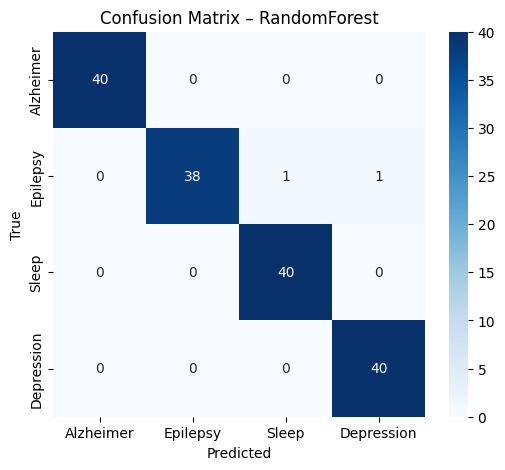

In [ ]:
# 1) RandomForest on flattened data
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)
rf = RandomForestClassifier(n_estimators=RF_TREES, random_state=RANDOM_STATE)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=CLASS_NAMES))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix – RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# 2) Enhanced CNN
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat  = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

def build_cnn(input_shape, num_classes):
    """
    Build a simple CNN for multi-class EEG classification.
    """
    model = Sequential([
        Conv1D(16, 5, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Conv1D(32, 3, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn((NUM_TIMESTEPS, NUM_CHANNELS), NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=CNN_EPOCHS,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.3230 - loss: 1.9041 - val_accuracy: 0.7188 - val_loss: 1.0479
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5637 - loss: 0.9339 - val_accuracy: 0.7500 - val_loss: 0.4488
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7740 - loss: 0.4704 - val_accuracy: 0.8281 - val_loss: 0.3296
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8472 - loss: 0.3203 - val_accuracy: 1.0000 - val_loss: 0.2286
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9237 - loss: 0.2258 - val_accuracy: 1.0000 - val_loss: 0.1290
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9500 - loss: 0.1535 - val_accuracy: 1.0000 - val_loss: 0.0734
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9452 - loss: 0.1429 - val_accuracy: 1.0000 - val_loss: 0.0457
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9647 - loss: 0.1158 - val_accuracy: 1.0000 - val_loss

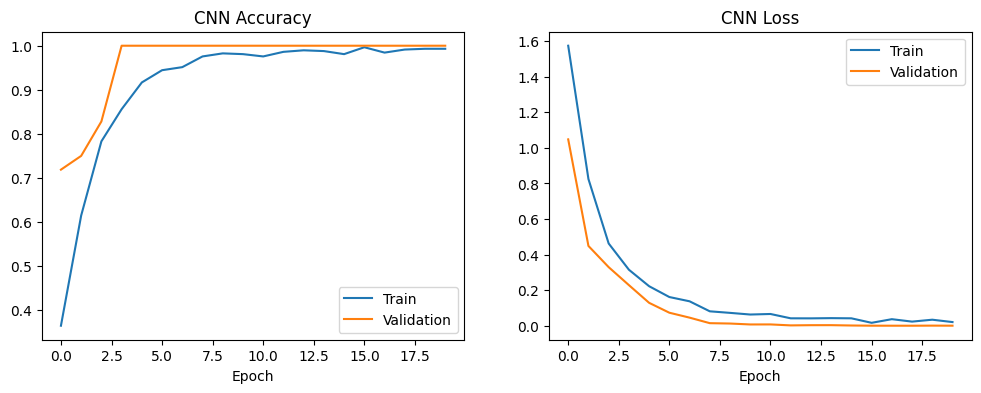

In [ ]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
CNN Classification Report:
              precision    recall  f1-score   support

   Alzheimer       1.00      1.00      1.00        40
    Epilepsy       1.00      1.00      1.00        40
       Sleep       1.00      1.00      1.00        40
  Depression       1.00      1.00      1.00        40

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



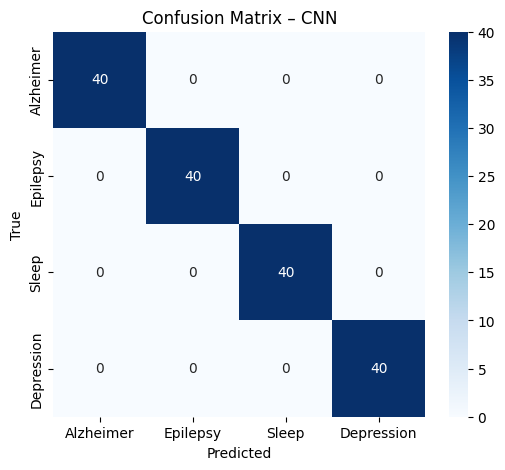

In [ ]:
# Evaluate CNN
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=CLASS_NAMES))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix – CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

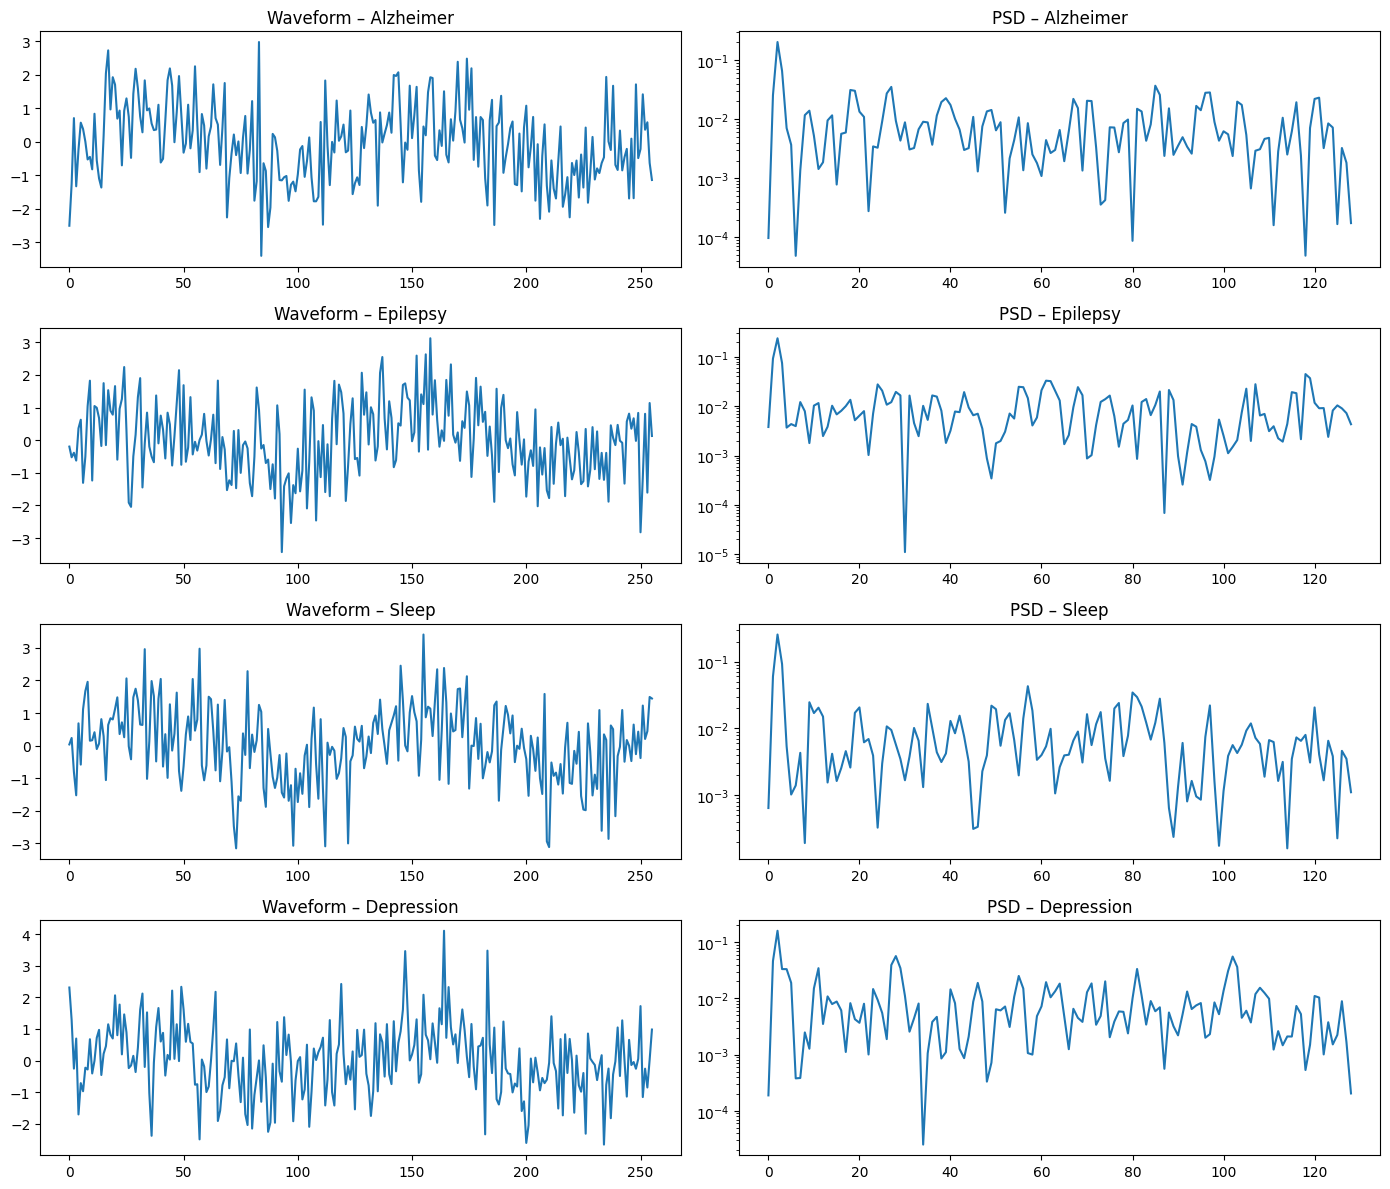

In [ ]:
# 3) Example Waveforms and PSD
plt.figure(figsize=(14,12))
for i in range(NUM_CLASSES):
    sample = X[i * 10]
    channel0 = sample[:, 0]
    plt.subplot(NUM_CLASSES, 2, 2*i+1)
    plt.plot(channel0)
    plt.title(f"Waveform – {CLASS_NAMES[i]}")
    plt.subplot(NUM_CLASSES, 2, 2*i+2)
    freqs, psd = welch(channel0, fs=256)
    plt.semilogy(freqs, psd)
    plt.title(f"PSD – {CLASS_NAMES[i]}")
plt.tight_layout()
plt.show()